# [Unconditional] GAN with TensorFlow TFGAN

Based on [tfgan tutorial](https://github.com/tensorflow/models/blob/master/research/gan/tutorial.ipynb). This is a demo for a presentation I did about GANs.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.gan as tfgan
from mnist import MNIST # pip install --user python-mnist
from urllib.parse import urlparse
from urllib.request import urlretrieve
%matplotlib inline
layers = tf.contrib.layers
framework = tf.contrib.framework

Download and load the dataset.

In [2]:
files = [
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
]

def download(url, fn, force=False):
    if force or not os.path.exists(fn):
        urlretrieve(url, fn)
        print("Downloaded", fn)
    else:
        print("Already downloaded", fn)

for f in files:
    download(f, os.path.basename(urlparse(f).path))

Already downloaded train-images-idx3-ubyte.gz
Already downloaded train-labels-idx1-ubyte.gz
Already downloaded t10k-images-idx3-ubyte.gz
Already downloaded t10k-labels-idx1-ubyte.gz


In [3]:
mndata = MNIST('.', return_type='numpy', gz=True)
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()
assert train_images.shape[0] == train_labels.shape[0]
assert test_images.shape[0] == test_labels.shape[0]

Reshape the 60,000 784x1 images to 60,000 28x28 images and normalize.

In [4]:
train_images = (train_images.reshape(-1,28,28,1).astype(np.float32) - 128.0) / 128.0
test_images = (test_images.reshape(-1,28,28,1).astype(np.float32) - 128.0) / 128.0

Visualize digits.

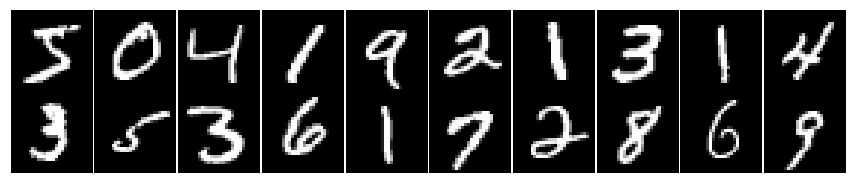

In [5]:
def show(images, num=20, cols=10):
    fig = plt.figure(figsize=(15,3))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(num):
        ax = fig.add_subplot(np.ceil(num/cols), cols, i+1)
        ax.grid(False); ax.set_yticks([]); ax.set_xticks([]); plt.axis('off')
        plt.imshow(np.squeeze(images[i]), cmap='gray')
    plt.show()

show(train_images)

## Unconditional GAN

First, define networks.

In [6]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """ Noise input, L2 weight decay, training boolean for Batch norm """
    with framework.arg_scope(
            [layers.fully_connected, layers.conv2d_transpose],
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_regularizer=layers.l2_regularizer(weight_decay)
        ), framework.arg_scope([layers.batch_norm],
            is_training=is_training, zero_debias_moving_mean=True):
        n = layers.fully_connected(noise, 1024)
        n = layers.fully_connected(n, 7*7*256)
        n = tf.reshape(n, [-1,7,7,256])
        n = layers.conv2d_transpose(n, 64, [4,4], stride=2)
        n = layers.conv2d_transpose(n, 32, [4,4], stride=2)
        # Make sure generator output is in same range as inputs, i.e. [-1,1]
        n = layers.conv2d(n, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)
        return n

def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5, is_training=True):
    """ Noise input, conditional input (not used), L2 weight decay, training boolean for Batch norm """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        n = layers.conv2d(img, 64, [4,4], stride=2)
        n = layers.conv2d(n, 128, [4,4], stride=2)
        n = layers.flatten(n)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            n = layers.fully_connected(n, 1024, normalizer_fn=layers.batch_norm)
        n = layers.linear(n, 1)
        return n

Then some not-so-pretty code to get numpy data into Tensorflow. To reduce memory usage this feeds in the data through placeholders, but that requires a hook to initialize the iterator...

In [7]:
class IteratorInitializerHook(tf.train.SessionRunHook):
    """Hook to initialise data iterator after Session is created.
    https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0"""
    def __init__(self):
        super(IteratorInitializerHook, self).__init__()
        self.iter_init_func = None

    def after_create_session(self, sess, coord):
        """Initialize the iterator after the session has been created."""
        self.iter_init_func(sess)

def _get_train_input_fn(features, labels, batch_size, noise_dims, seed):
    iter_init_hook = IteratorInitializerHook()
    
    def train_input_fn():
        # Input images using placeholders to reduce memory usage
        features_placeholder = tf.placeholder(features.dtype, features.shape)
        labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
        dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
        dataset = dataset.shuffle(5000,seed=seed).batch(batch_size)
        iterator = dataset.make_initializable_iterator()
        next_image_batch, next_label_batch = iterator.get_next()
        
        # Input noise for generator
        noise = tf.random_normal([batch_size, noise_dims])
        
        # Need to initialize iterator after creating a session in the estimator
        iter_init_hook.iter_init_func = lambda sess: sess.run(
            iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})
        
        return noise, next_image_batch
    return train_input_fn, iter_init_hook

def _get_predict_input_fn(batch_size, noise_dims):
    def predict_input_fn():
        noise = tf.random_normal([batch_size, noise_dims])
        return noise
    return predict_input_fn

### Not using an Estimator

More verbose but provides more details into what is happening.

In [8]:
tf.reset_default_graph()
    
def train(features, labels, noise_dims=64, batch_size=32, num_steps=1200, num_eval=20, seed=0):
    """ Input features (images) and labels, noise vector dimension, batch size, seed for reproducibility """
    # Input training data and noise
    train_input_fn, train_input_hook = \
        _get_train_input_fn(features, labels, batch_size, noise_dims, seed)
    noise, next_image_batch = train_input_fn()
    
    # Define GAN model, loss, and optimizers
    model = tfgan.gan_model(generator_fn, discriminator_fn, next_image_batch, noise)
    loss = tfgan.gan_loss(model,
                generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
                discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
                gradient_penalty_weight=1.0)
    generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
    discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
    gan_train_ops = tfgan.gan_train_ops(
        model, loss, generator_optimizer, discriminator_optimizer)
    
    # We'll evaluate images during training to see how the generator improves
    with tf.variable_scope('Generator', reuse=True):
        predict_input_fn = _get_predict_input_fn(num_eval, noise_dims)
        eval_images = model.generator_fn(predict_input_fn(), is_training=False)
    
    # Train, outputting evaluation occasionally
    train_step_fn = tfgan.get_sequential_train_steps()
    global_step = tf.train.get_or_create_global_step()
    
    with tf.train.SingularMonitoredSession(hooks=[train_input_hook]) as sess:
        for i in range(num_steps+1):
            cur_loss, _ = train_step_fn(
                sess, gan_train_ops, global_step, train_step_kwargs={})
            if i % 400 == 0:
                generated_images = sess.run(eval_images)
                print("Iteration", i, "- Loss:", cur_loss)
                show(generated_images)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteration 0 - Loss: 0.5452417656779289


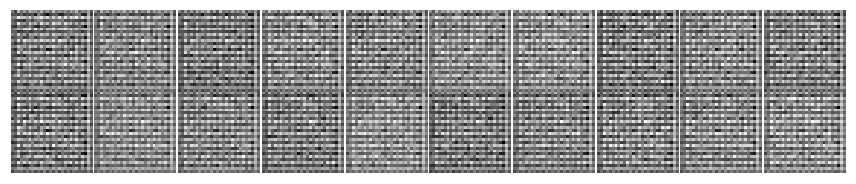

Iteration 400 - Loss: -2.687541663646698


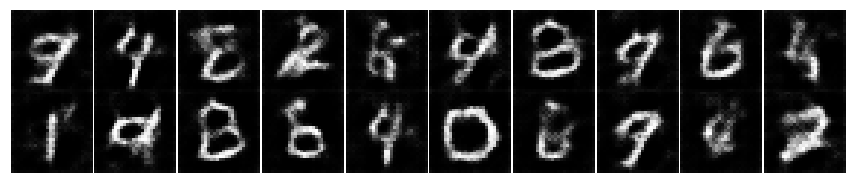

Iteration 800 - Loss: -2.619133412837982


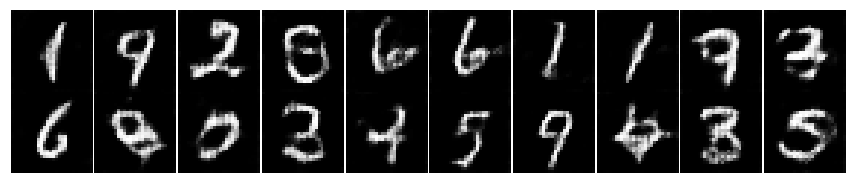

Iteration 1200 - Loss: -3.416516661643982


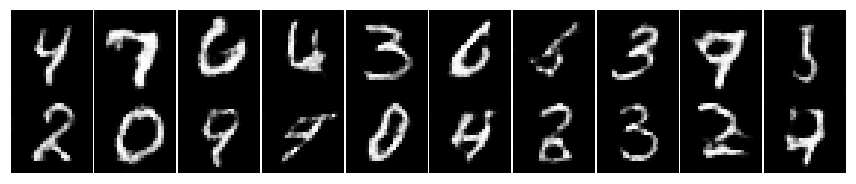

In [9]:
train(train_images, train_labels)

### Using an Estimator

Another way, using a TensorFlow estimator. This easily allows for saving and restoring from checkpoints, viewing progress in TensorBoard, etc.

In [12]:
tf.reset_default_graph()

def train(features, labels, noise_dims=64, batch_size=32, num_steps=1200, num_eval=20, seed=0):
    gan_estimator = tfgan.estimator.GANEstimator(
        generator_fn=generator_fn,
        discriminator_fn=discriminator_fn,
        generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
        discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
        generator_optimizer=tf.train.AdamOptimizer(0.001, 0.5),
        discriminator_optimizer=tf.train.AdamOptimizer(0.0001, 0.5),
        model_dir="gan-model")
        #add_summaries=tfgan.estimator.SummaryType.IMAGES)

    train_input_fn, train_input_hook = \
        _get_train_input_fn(features, labels, batch_size, noise_dims, seed)
    gan_estimator.train(train_input_fn, max_steps=num_steps, hooks=[train_input_hook])

    # Evaluate
    predict_input_fn = _get_predict_input_fn(num_eval, noise_dims)
    prediction_iterable = gan_estimator.predict(
        predict_input_fn, hooks=[tf.train.StopAtStepHook(last_step=1)])
    predictions = [prediction_iterable.__next__() for _ in range(num_eval)]

    try: # Close the predict session.
        prediction_iterable.__next__()
    except StopIteration:
        pass
    
    show(predictions)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'gan-model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7feafc09c710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gan-model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving

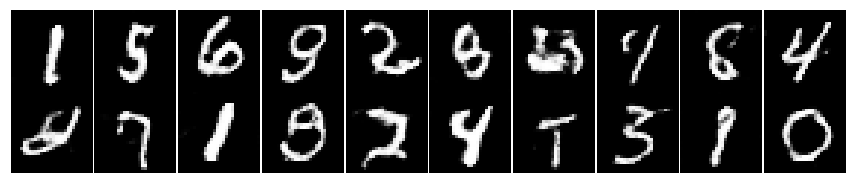

In [13]:
train(train_images, train_labels)